# About the Project

We would be reimplmenting the popular some of the models in the [PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts. ](https://https://arxiv.org/pdf/1710.06071.pdf)
paper using the dataset provided in thier github [page](https://https://github.com/Franck-Dernoncourt/pubmed-rct)

Abstract
> PubMed 200k RCT is new dataset based on PubMed for sequential sentence classification. The dataset consists of approximately 200,000 abstracts of randomized controlled trials, totaling 2.3 million sentences. Each sentence of each abstract is labeled with their role in the abstract using one of the following classes: background, objective, method, result, or conclusion. The purpose of releasing this dataset is twofold. First, the majority of datasets for sequential short-text classification (i.e., classification of short texts that appear in sequences) are small: we hope that releasing a new large dataset will help develop more accurate algorithms for this task. Second, from an application perspective, researchers need better tools to efficiently skim through the literature. Automatically classifying each sentence in an abstract would help researchers read abstracts more efficiently, especially in fields where abstracts may be long, such as the medical field.


This is an implementation of the second baseline of the paper. The was based on the Sequential Short-Text Classification with Recurrent and Convolutional Neural Networks [paper](https://https://arxiv.org/abs/1603.03827)

Abstract
> Recent approaches based on artificial neural networks (ANNs) have shown promising results for short-text classification. However, many short texts occur in sequences (e.g., sentences in a document or utterances in a dialog), and most existing ANN-based systems do not leverage the preceding short texts when classifying a subsequent one. In this work, we present a model based on recurrent neural networks and convolutional neural networks that incorporates the preceding short texts. Our model achieves state-of-the-art results on three different datasets for dialog act prediction.

# The Essential Libraries

## Import the model

In [ ]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import keras_tuner

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# The Dataset

The dataset for provided for the model can be found in thier github page [here](https://https://github.com/Franck-Dernoncourt/pubmed-rct).

The fist step is clonning the repo using

```
git clone repo
```

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 10.73 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


Some miscellaneous information:

- PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
- `PubMed_200k_RCT` is the same as `PubMed_200k_RCT_numbers_replaced_with_at_sign`, except that in the latter all numbers had been replaced by `@`. (same for `PubMed_20k_RCT` vs. `PubMed_20k_RCT_numbers_replaced_with_at_sign`).
- Since Github file size limit is [100 MiB](https://stackoverflow.com/a/43098961/395857), we had to compress `PubMed_200k_RCT\train.7z` and `PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip`.


We need to uncompress the file. We would be using unzip function provided in the linux terminal by default



```
unzip directory_of_zip_file -d destination_directory
```


In [ ]:
!unzip /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

Archive:  /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: /content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


# Preprocess the Dataset

In [ ]:
# Lets read a single file from the dataset
with open("/content/pubmed-rct/PubMed_20k_RCT/train.txt") as train:
    data = train.read()

#Let read a small portion of the dataset
print(data[:5000])

###24293578
OBJECTIVE	To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( 0-100 mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .
METHODS	Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein

All files are in one file. So to use it we need to split into thier individual parts.

- Articles are splitted using double newline
- The ID of the articles are defined using ###
- The part it identifies using a tab

Lets wrap everything in a function

In [ ]:
# Let create a function to divide the dataset into smaller portions
def split_pubmed_into_part(text):
  # Split the dataset into articles
  abstracts = text.split("\n\n")

  # Split the abstract into lines
  abstracts = [line.split("\n") for line in abstracts]

  # Let store all the values in a dictionary of
  # ID, TAG, TEXT and store it.
  All_lines = []

  for abstract in abstracts:

    ## Save the ID
    ID = abstract[0].replace("###", "")

    no_sent = len(abstract)
    ## Loop over the remaining values
    for index in range(1, no_sent, 1):
      line = abstract[index]
      ## Split the line into tag, text
      line = line.split("\t")

      ## Save the ID, TAG and TEXT, PREV_TEXT1, PREV_TEXT2
      ## Tage would be the first index and text the second index
      if(index <= 2):
        line_values = {
            "id"  : ID,
            "index": index,
            "tag" : line[0],
            "text": line[1],
            "prev_1": "",
            "prev_2":""}

      else:
        line_values = {
            "id"  : ID,
            "index": index,
            "tag" : line[0],
            "text": line[1],
            "prev_1": All_lines[-1]['text'],
            "prev_2": All_lines[-2]['text']}

      ## Append it to the dataset
      All_lines.append(line_values)

  return All_lines

In [ ]:
values = split_pubmed_into_part(data)
values[:5]

[{'id': '24293578',
  'index': 1,
  'tag': 'OBJECTIVE',
  'text': 'To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'prev_1': '',
  'prev_2': ''},
 {'id': '24293578',
  'index': 2,
  'tag': 'METHODS',
  'text': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'prev_1': '',
  'prev_2': ''},
 {'id': '24293578',
  'index': 3,
  'tag': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'prev_1': 'A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .',
  'prev_2': 'To investigate the e

In [ ]:
# Lets make it look better
train = pd.DataFrame(values)
train.head()

,id,index,tag,text,prev_1,prev_2
0,24293578,1,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,,
1,24293578,2,METHODS,A total of 125 patients with primary knee OA w...,,
2,24293578,3,METHODS,Outcome measures included pain reduction and i...,A total of 125 patients with primary knee OA w...,To investigate the efficacy of 6 weeks of dail...
3,24293578,4,METHODS,Pain was assessed using the visual analog pain...,Outcome measures included pain reduction and i...,A total of 125 patients with primary knee OA w...
4,24293578,5,METHODS,Secondary outcome measures included the Wester...,Pain was assessed using the visual analog pain...,Outcome measures included pain reduction and i...


## Lets wrap it into a simple function

In [ ]:
def preprocess_pubmed(path):
  # Lets read a single file from the dataset
  with open(path) as text:
      data = text.read()


  # Preprocess it
  values = split_pubmed_into_part(data)

  # Save it has a dataframe
  df = pd.DataFrame(values)

  return df

## Read the dataset

20K

In [ ]:
train_20k_path = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt"
test_20k_path = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt"
dev_20k_path = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt"

In [ ]:
train_20k = preprocess_pubmed(train_20k_path)
test_20k = preprocess_pubmed(test_20k_path)
dev_20k = preprocess_pubmed(dev_20k_path)

200k

In [ ]:
train_200k_path = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt"
test_200k_path = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt"
dev_200k_path = "/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt"

In [ ]:
train_200k = preprocess_pubmed(train_200k_path)
test_200k = preprocess_pubmed(test_200k_path)
dev_200k = preprocess_pubmed(dev_200k_path)

## Explore the Dataset

The dataset is constructed upon the MEDLINE/PubMed Database published in
2016 , which we will refer to as PubMed in this paper. PubMed can be accessed online by anyone, free of charge and without having to go through any registration. It contains 24,358,442 records.
A record typically consists of metadata on one article, as well as the article’s title and in many cases its abstract.

The dataset comes in two version a larger 200k abstract which can be to much for so many application and also a 20k version. So we would be making our initial experimentation with the 20k then make our final experimentation with the 200k dataset

In [ ]:
print("=============20k=============")
print(f"Train 20k files contain {train_20k.id.nunique()}")
print(f"Test  20k files contain  {test_20k.id.nunique()}")
print(f"Dev   20k files contain  {dev_20k.id.nunique()}")

=============20k=============
Train 20k files contain 15000
Test  20k files contain  2500
Dev   20k files contain  2500


Total sentences: 20000

In [ ]:
print("=============200k==============")
print(f"Train 200k files contain {train_200k.id.nunique()}")
print(f"Test  200k files contain   {test_200k.id.nunique()}")
print(f"Dev   200k files contain   {dev_200k.id.nunique()}")

=============200k==============
Train 200k files contain 190654
Test  200k files contain   2500
Dev   200k files contain   2500


Total sentences: 195,654

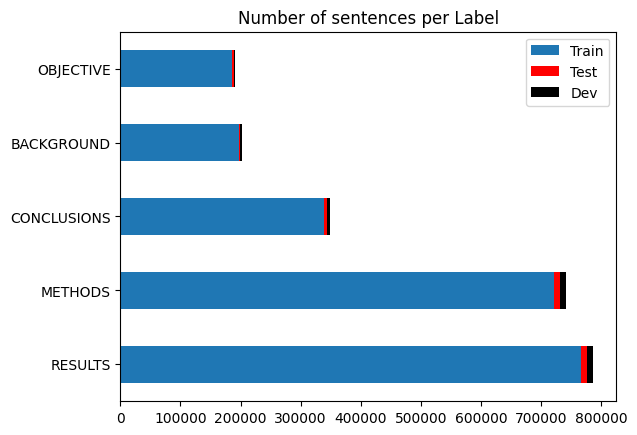

In [ ]:
train_200k_vc = train_200k['tag'].value_counts()
test_200k_vc = test_200k['tag'].value_counts()
dev_200k_vc = dev_200k['tag'].value_counts()

train_200k_vc.plot(kind = 'barh',
                   label = 'Train')
test_200k_vc.plot(kind = 'barh',
                  color = 'red',
                  label = "Test",
                  left = train_200k_vc.values)
dev_200k_vc.plot(kind = 'barh',
                 color = 'black',
                 label = "Dev",
                 left = np.array([train_200k_vc.values, dev_200k_vc.values]).sum(axis = 0))

plt.title("Number of sentences per Label")
plt.legend()
plt.show()

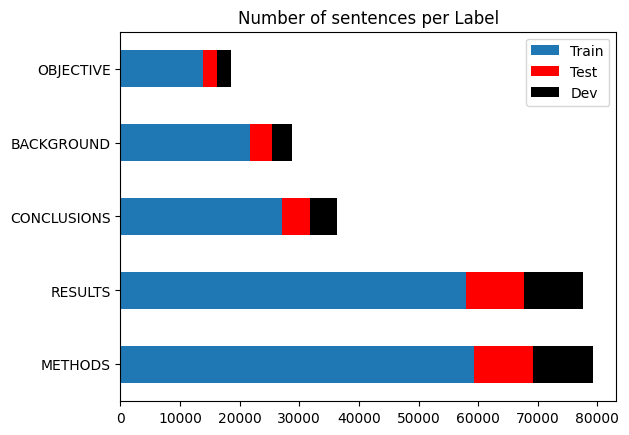

In [ ]:
train_20k_vc = train_20k['tag'].value_counts()
test_20k_vc = test_20k['tag'].value_counts()
dev_20k_vc = dev_20k['tag'].value_counts()

train_20k_vc.plot(kind = 'barh',
                   label = 'Train')
test_20k_vc.plot(kind = 'barh',
                  color = 'red',
                  label = "Test",
                  left = train_20k_vc.values)

dev_20k_vc.plot(kind = 'barh',
                 color = 'black',
                 label = "Dev",
                 left = np.array([train_20k_vc.values, test_20k_vc.values]).sum(axis = 0))

plt.title("Number of sentences per Label")
plt.legend()
plt.show()

## Lets check some portions

In [ ]:
train_200k.head()

,id,index,tag,text,prev_1,prev_2
0,24491034,1,BACKGROUND,The emergence of HIV as a chronic condition me...,,
1,24491034,2,BACKGROUND,This paper describes the design and evaluation...,,
2,24491034,3,METHODS,This study is designed as a randomised control...,This paper describes the design and evaluation...,The emergence of HIV as a chronic condition me...
3,24491034,4,METHODS,The intervention group will participate in the...,This study is designed as a randomised control...,This paper describes the design and evaluation...
4,24491034,5,METHODS,The program is based on self-efficacy theory a...,The intervention group will participate in the...,This study is designed as a randomised control...


In [ ]:
train_200k['tag'].unique()

array(['BACKGROUND', 'METHODS', 'CONCLUSIONS', 'RESULTS', 'OBJECTIVE'],
      dtype=object)

# The Model

In [ ]:
sentences = pd.concat([train_20k['text'], dev_20k['text']])

In [ ]:
# Tokenization Layer
max_tokens = 10000
max_length = 15

Vectorizer = TextVectorization(max_tokens = max_tokens,
                               output_sequence_length = max_length)

Vectorizer.adapt(sentences)

In [ ]:
Embedding_layer = Embedding(input_dim = max_tokens,
                            output_dim = 128,
                            input_length = max_length)

## Text to Vectorization layer

This layer takes in the sentences and create and generates a vector representation of it.

In [ ]:
## Define the S2V modedel
input_layer = Input(shape = (1,), dtype = 'string')
print(input_layer.shape)
Vectorizer_layer = Vectorizer(input_layer)
print(Vectorizer_layer.shape)
embedding_output_layer = Embedding_layer(Vectorizer_layer)
print(embedding_output_layer.shape)
lstm_layer = LSTM(100)(embedding_output_layer)
print(lstm_layer.shape)
output_layer = Dense(10, activation='relu')(lstm_layer)
print(output_layer.shape)
text_2_Vector_model = tf.keras.Model(input_layer, output_layer)

(None, 1)
(None, 15)
(None, 15, 128)
(None, 100)
(None, 10)


In [ ]:
text_2_Vector_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 1372610 (5.24 MB)
Trainable params: 1372610 (5.24 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

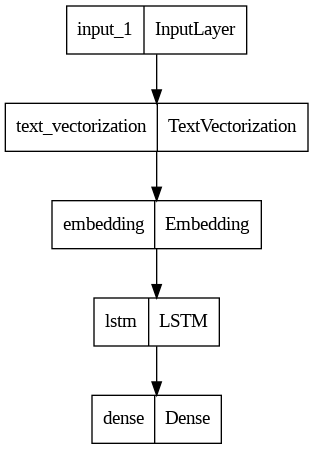

In [ ]:
plot_model(text_2_Vector_model)

## Layer for processing the current sequences

In [ ]:
# The Processing the current text
input_current_layer = Input(shape = (1,), dtype = 'string')
text_2_Vector_layer = text_2_Vector_model(input_current_layer)
output_current_layer = Dense(10, activation='relu')(text_2_Vector_layer)
current_model = tf.keras.Model(input_current_layer, output_current_layer)
print(output_current_layer.shape)

(None, 10)


In [ ]:
current_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 model (Functional)          (None, 10)                1372610   
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 1372720 (5.24 MB)
Trainable params: 1372720 (5.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


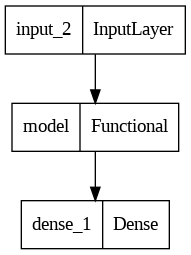

In [ ]:
plot_model(current_model)

## Layer for processing the first previous sequences

In [ ]:
## Define input for preceding layer 1
input_preceeding_layer_1 = Input(shape = (1,), dtype = 'string')
text_2_Vector_preceding_layer_1 = text_2_Vector_model(input_preceeding_layer_1)
output_preceeding_layer_1 = Dense(10, activation='sigmoid')(text_2_Vector_preceding_layer_1)
preceeding_model_1 = tf.keras.Model(input_preceeding_layer_1, output_preceeding_layer_1)
print(output_preceeding_layer_1.shape)

(None, 10)


In [ ]:
preceeding_model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 model (Functional)          (None, 10)                1372610   
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
Total params: 1372720 (5.24 MB)
Trainable params: 1372720 (5.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


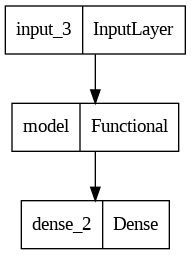

In [ ]:
plot_model(preceeding_model_1)

## Layer for processing the second previous sequences

In [ ]:
## Define input for preceding layer 2
input_preceeding_layer_2 = Input(shape = (1,), dtype = 'string')
text_2_Vector_preceding_layer_2 = text_2_Vector_model(input_preceeding_layer_2)
output_preceeding_layer_2 = Dense(10, activation='sigmoid')(text_2_Vector_preceding_layer_2)
print(output_preceeding_layer_2.shape)
preceeding_model_2 = tf.keras.Model(input_preceeding_layer_2, output_preceeding_layer_2)

(None, 10)


In [ ]:
preceeding_model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 model (Functional)          (None, 10)                1372610   
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 1372720 (5.24 MB)
Trainable params: 1372720 (5.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


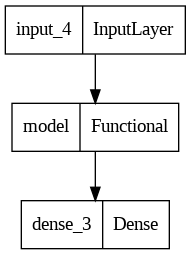

In [ ]:
plot_model(preceeding_model_2)

## Blend all into a layer

In [ ]:
# Concatentate
concatenate_layer = tf.keras.layers.Concatenate(name = "Concatenate_Layer")([current_model.output, preceeding_model_1.output, preceeding_model_2.output])

# Final layer
x = tf.keras.layers.Dropout(0.2)(concatenate_layer)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
Output = tf.keras.layers.Dense(5, activation = 'softmax', name = "output")(x)
print(Output.shape)
Feed_forward_Model = tf.keras.Model([current_model.input, preceeding_model_1.input, preceeding_model_2.input], Output)

(None, 5)


In [ ]:
Feed_forward_Model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model (Functional)          (None, 10)                   1372610   ['input_2[0][0]',             
                                                                     'input_3[0][0]',       

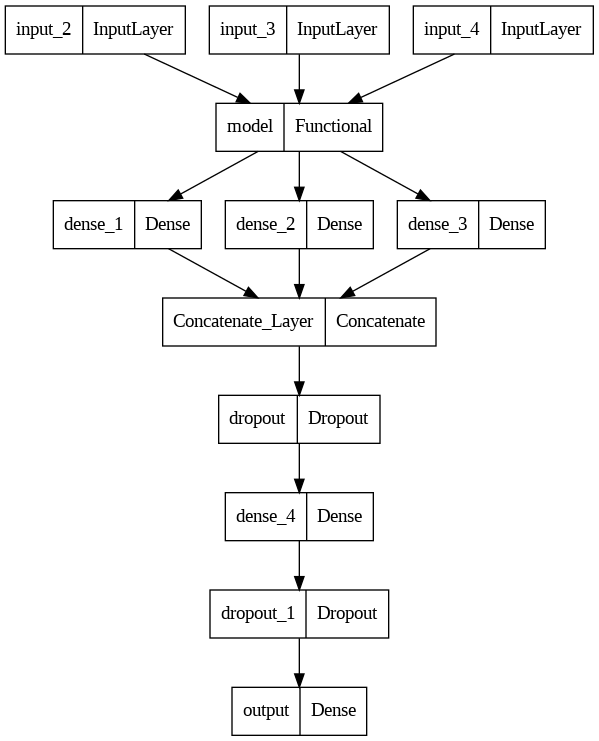

In [ ]:
# Plot hybrid token and character model
plot_model(Feed_forward_Model)

# The Dataset

Let make dataset in the format that can be used by the model

In [ ]:
train_20k.head()

,id,index,tag,text,prev_1,prev_2
0,24293578,1,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,,
1,24293578,2,METHODS,A total of @ patients with primary knee OA wer...,,
2,24293578,3,METHODS,Outcome measures included pain reduction and i...,A total of @ patients with primary knee OA wer...,To investigate the efficacy of @ weeks of dail...
3,24293578,4,METHODS,Pain was assessed using the visual analog pain...,Outcome measures included pain reduction and i...,A total of @ patients with primary knee OA wer...
4,24293578,5,METHODS,Secondary outcome measures included the Wester...,Pain was assessed using the visual analog pain...,Outcome measures included pain reduction and i...


In [ ]:
Encoder = LabelEncoder()
y_train_encode = Encoder.fit_transform(train_20k['tag'])

In [ ]:
train_20k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(train_20k["tag"]))
test_20k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(test_20k["tag"]))
dev_20k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(dev_20k["tag"]))

train_20k_sentences = tf.data.Dataset.from_tensor_slices((train_20k["text"],train_20k["prev_1"], train_20k["prev_2"]))
test_20k_sentences = tf.data.Dataset.from_tensor_slices((test_20k["text"],test_20k["prev_1"], test_20k["prev_2"]))
dev_20k_sentences = tf.data.Dataset.from_tensor_slices((dev_20k["text"],dev_20k["prev_1"], dev_20k["prev_2"]))

train_20k_dataset = tf.data.Dataset.zip(train_20k_sentences, train_20k_labels)
test_20k_dataset = tf.data.Dataset.zip(test_20k_sentences, test_20k_labels)
dev_20k_dataset = tf.data.Dataset.zip(dev_20k_sentences,  dev_20k_labels)

In [ ]:
train_20k_dataset = train_20k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_20k_dataset = dev_20k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_20k_dataset = test_20k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the Model

Lets train the base model for only 5 epochs to test it performance

In [ ]:
# Train the model
Feed_forward_Model.compile(optimizer = "Adam",
                loss = "SparseCategoricalCrossentropy",
                metrics = ["Accuracy"])

Feed_forward_Model.fit(train_20k_dataset,
                       steps_per_epoch = int(0.2 * len(train_20k_dataset)),
                       epochs=5,
                       batch_size = 32,
                       validation_data = dev_20k_dataset,
                       )

Epoch 1/5
1125/1125 [==============================] - 48s 33ms/step - loss: 0.8077 - Accuracy: 0.6768 - val_loss: 0.5406 - val_Accuracy: 0.7903
Epoch 2/5
1125/1125 [==============================] - 25s 22ms/step - loss: 0.5653 - Accuracy: 0.7790 - val_loss: 0.4851 - val_Accuracy: 0.8137
Epoch 3/5
1125/1125 [==============================] - 31s 28ms/step - loss: 0.5461 - Accuracy: 0.7873 - val_loss: 0.4555 - val_Accuracy: 0.8295
Epoch 4/5
1125/1125 [==============================] - 29s 26ms/step - loss: 0.4914 - Accuracy: 0.8141 - val_loss: 0.4528 - val_Accuracy: 0.8385
Epoch 5/5
1125/1125 [==============================] - 29s 26ms/step - loss: 0.4716 - Accuracy: 0.8240 - val_loss: 0.4366 - val_Accuracy: 0.8376


# Evaluate the Model

In [ ]:
# Make predictions on the test data
y_pred_proba = Feed_forward_Model.predict(test_20k_dataset)
y_pred = y_pred_proba.argmax(axis = 1)

942/942 [==============================] - 7s 6ms/step


In [ ]:
y_true = Encoder.transform(test_20k["tag"])

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.8320225651236104

In [ ]:
clfreport = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(clfreport)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75      3621
           1       0.83      0.78      0.80      4571
           2       0.91      0.87      0.89      9897
           3       0.77      0.49      0.60      2333
           4       0.83      0.91      0.87      9713

    accuracy                           0.83     30135
   macro avg       0.81      0.77      0.78     30135
weighted avg       0.83      0.83      0.83     30135



In [ ]:
# classes = test_20k["tag"].unique()
classes = Encoder.classes_
classes

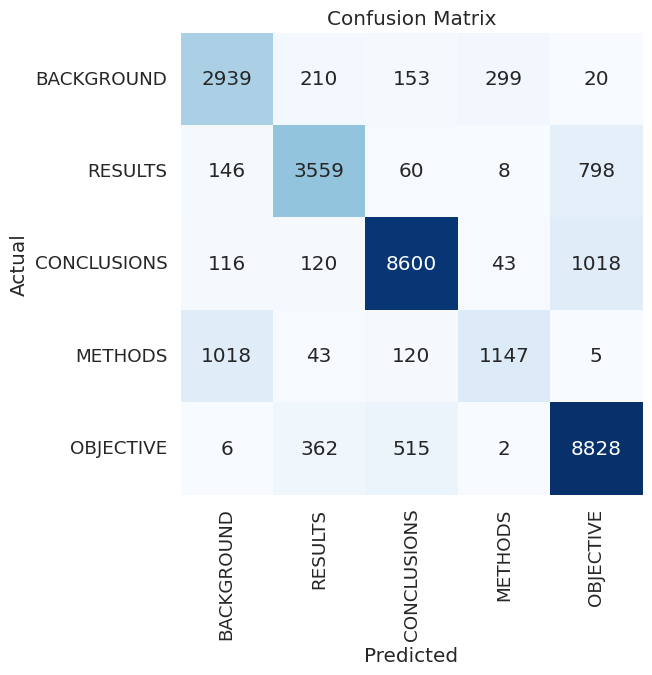

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes,  # Replace with your class labels
            yticklabels=classes)  # Replace with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The model is already performing well we might just need to improve the performance by using keras tuner to find the optimal parameter

# Improve the performance using Keras Tuner

In [ ]:
hp = keras_tuner.HyperParameters()
print(hp.Int("units", min_value=32, max_value=512, step=32))

32


In [ ]:
def tuner_model(hp):
  # Define the architecture of the forward ANN model

  ## Define the S2V modedel
  input_layer = Input(shape = (1,), dtype = 'string')
  print(input_layer.shape)
  Vectorizer_layer = Vectorizer(input_layer)
  print(Vectorizer_layer.shape)
  embedding_output_layer = Embedding_layer(Vectorizer_layer)
  print(embedding_output_layer.shape)
  lstm_layer = LSTM(100)(embedding_output_layer)
  print(lstm_layer.shape)
  output_layer = Dense(10, activation='relu')(lstm_layer)
  text_2_Vector_model = tf.keras.Model(input_layer, output_layer)

  ## Define input for current layer
  input_current_layer = Input(shape = (1,), dtype = 'string')
  text_2_Vector_layer = text_2_Vector_model(input_current_layer)
  output_current_layer = Dense(10, activation='relu')(text_2_Vector_layer)
  current_model = tf.keras.Model(input_current_layer, output_current_layer)
  print(output_current_layer.shape)

  ## Define input for preceding layer 1
  input_preceeding_layer_1 = Input(shape = (1,), dtype = 'string')
  text_2_Vector_preceding_layer_1 = text_2_Vector_model(input_preceeding_layer_1)
  output_preceeding_layer_1 = Dense(10, activation='sigmoid')(text_2_Vector_preceding_layer_1)
  preceeding_model_1 = tf.keras.Model(input_preceeding_layer_1, output_preceeding_layer_1)
  print(output_preceeding_layer_1.shape)

  ## Define input for preceding layer 2
  input_preceeding_layer_2 = Input(shape = (1,), dtype = 'string')
  text_2_Vector_preceding_layer_2 = text_2_Vector_model(input_preceeding_layer_2)
  output_preceeding_layer_2 = Dense(10, activation='sigmoid')(text_2_Vector_preceding_layer_2)
  preceeding_model_2 = tf.keras.Model(input_preceeding_layer_2, output_preceeding_layer_2)

  # Concatentate
  concatenate_layer = tf.keras.layers.Concatenate(name = "Concatenate_Layer")([current_model.output, preceeding_model_1.output, preceeding_model_2.output])

  # Final layer
  x = tf.keras.layers.Dropout(hp.Float("Drop_1_rate", min_value=0, max_value=0.8, step=0.1))(concatenate_layer)
  x = tf.keras.layers.Dense(hp.Int("units", min_value=32, max_value=512, step=32), activation = 'relu')(x)
  x = tf.keras.layers.Dropout(hp.Float("Drop_2_rate", min_value=0, max_value=0.8, step=0.1))(x)
  Output = tf.keras.layers.Dense(5, activation = 'softmax', name='output_node')(x)
  Feed_forward_Model = tf.keras.Model([current_model.input, preceeding_model_1.input, preceeding_model_2.input], Output)
  Feed_forward_Model.compile(optimizer = "Adam",
                loss = "SparseCategoricalCrossentropy",
                metrics = ["Accuracy"])
  return Feed_forward_Model

In [ ]:
tuner_model(keras_tuner.HyperParameters())

(None, 1)
(None, 15)
(None, 15, 128)
(None, 100)
(None, 10)
(None, 10)


In [ ]:
tuner = keras_tuner.RandomSearch(
    tuner_model,
    objective='val_loss',
    max_trials=5)

(None, 1)
(None, 15)
(None, 15, 128)
(None, 100)
(None, 10)
(None, 10)


For the tunned model. I tunned the model with a small portion of the dataset. To speed up the accuracy

In [ ]:
tuner.search(train_20k_dataset,
             steps_per_epoch = int(0.2 * len(train_20k_dataset)),
             epochs=5,
             batch_size = 32,
             validation_data = dev_20k_dataset)

Trial 5 Complete [00h 02m 28s]
val_loss: 0.44502273201942444

Best val_loss So Far: 0.39509817957878113
Total elapsed time: 00h 13m 48s


In [ ]:
best_model = tuner.get_best_models()[0]

(None, 1)
(None, 15)
(None, 15, 128)
(None, 100)
(None, 10)
(None, 10)


# Build the best Model

Use the best model to train the final model with
1. The whole data. The 200k dataset
2. The best parameters. All the parameters in the dataset

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
Best_model = tuner.hypermodel.build(best_hp)

(None, 1)
(None, 15)
(None, 15, 128)
(None, 100)
(None, 10)
(None, 10)


In [ ]:
Best_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 model_5 (Functional)        (None, 10)                   1372610   ['input_6[0][0]',             
                                                                     'input_7[0][0]',       

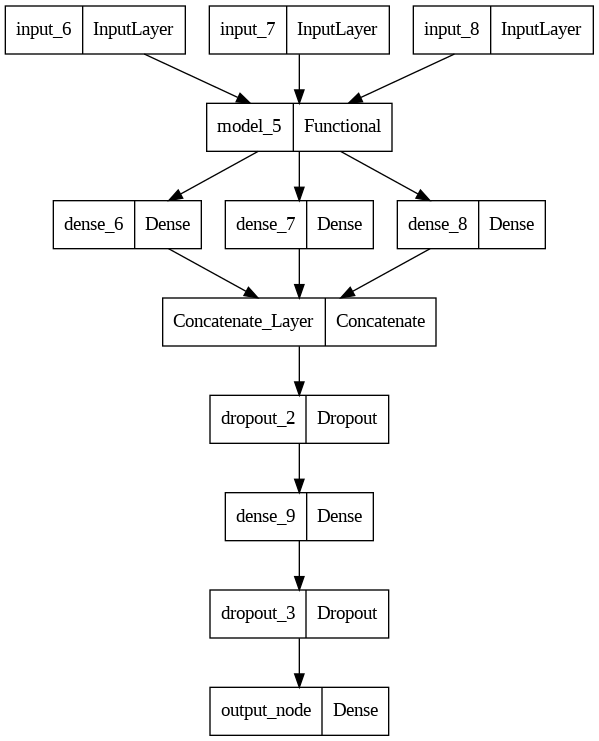

In [ ]:
# Plot hybrid token and character model
plot_model(Best_model)

## Define the full Dataset

In [ ]:
train_200k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(train_200k["tag"]))
test_200k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(test_200k["tag"]))
dev_200k_labels = tf.data.Dataset.from_tensor_slices(Encoder.transform(dev_200k["tag"]))

train_200k_sentences = tf.data.Dataset.from_tensor_slices((train_200k["text"],train_200k["prev_1"], train_200k["prev_2"]))
test_200k_sentences = tf.data.Dataset.from_tensor_slices((test_200k["text"],test_200k["prev_1"], test_200k["prev_2"]))
dev_200k_sentences = tf.data.Dataset.from_tensor_slices((dev_200k["text"],dev_200k["prev_1"], dev_200k["prev_2"]))

train_200k_dataset = tf.data.Dataset.zip(train_200k_sentences, train_200k_labels)
test_200k_dataset = tf.data.Dataset.zip(test_200k_sentences, test_200k_labels)
dev_200k_dataset = tf.data.Dataset.zip(dev_200k_sentences,  dev_200k_labels)

In [ ]:
train_200k_dataset = train_200k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
dev_200k_dataset = dev_200k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_200k_dataset = test_200k_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the model

In [ ]:
EarlystoppingCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    start_from_epoch=5
)

In [ ]:
# Train the model
Best_model.compile(optimizer = "Adam",
                loss = "SparseCategoricalCrossentropy",
                metrics = ["Accuracy"])

Best_model.fit(train_200k_dataset,
               callbacks = [EarlystoppingCallback],
               epochs=100, batch_size = 32, validation_data = dev_200k_dataset)

Epoch 1/100
69121/69121 [==============================] - 848s 12ms/step - loss: 0.3445 - Accuracy: 0.8702 - val_loss: 0.2940 - val_Accuracy: 0.8870
Epoch 2/100
69121/69121 [==============================] - 820s 12ms/step - loss: 0.2993 - Accuracy: 0.8871 - val_loss: 0.2868 - val_Accuracy: 0.8903
Epoch 3/100
69121/69121 [==============================] - 805s 12ms/step - loss: 0.2835 - Accuracy: 0.8929 - val_loss: 0.2846 - val_Accuracy: 0.8911
Epoch 4/100
69121/69121 [==============================] - 786s 11ms/step - loss: 0.2737 - Accuracy: 0.8965 - val_loss: 0.2860 - val_Accuracy: 0.8904
Epoch 5/100
69121/69121 [==============================] - 770s 11ms/step - loss: 0.2661 - Accuracy: 0.8994 - val_loss: 0.2889 - val_Accuracy: 0.8877
Epoch 6/100
69121/69121 [==============================] - 778s 11ms/step - loss: 0.2598 - Accuracy: 0.9015 - val_loss: 0.2885 - val_Accuracy: 0.8885
Epoch 7/100
69121/69121 [==============================] - 794s 11ms/step - loss: 0.2558 - Accuracy:

# Evaluate the Model

In [ ]:
# Make predictions on the test data
y_pred_proba = Best_model.predict(test_20k_dataset)
y_pred = y_pred_proba.argmax(axis = 1)

In [ ]:
y_true = Encoder.transform(test_20k["tag"])

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

In [ ]:
clfreport = classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(clfreport)

In [ ]:
classes = test_20k["tag"].unique()
classes

In [ ]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
            xticklabels=classes,  # Replace with your class labels
            yticklabels=classes)  # Replace with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the model

In [ ]:
Feed_forward_Model.summary()

In [ ]:
Feed_forward_Model.save('my_saved_model')

In [ ]:
!zip -r Model.zip my_saved_model